In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

1836


In [3]:
import cv2

In [4]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear'

folders, fovs = ia.io_tools.data.get_folders(data_folder)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 25
- Number of field of views: 205


In [5]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [7]:

for _fov_id, _fov_name in enumerate(fovs):
    
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    print(f"- seg file: {seg_save_file}")
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], 
                                    #diameter=25, 
                                    min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    corr_labels3d = np.array([cv2.resize(_ly, _cls.im_750.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(corr_labels3d.shape, _fov_id, _save_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    #break

- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_0.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_1.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_2.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_3.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_4.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_5.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_6.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_7.npy
- seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_no

# Run watershed

In [10]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed


In [9]:
segmentation_save_folder

'\\\\10.245.74.158\\Chromatin_NAS_6\\20220601-hSTG0308_250gene_noclear\\Segmentation'

In [13]:
for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id   
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file).astype(np.int16)
    #corr_labels3d[corr_labels3d==0] = -1
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    


- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_1.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.698s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.630s.
-- corrected illumination for channel 405 in 4.419s.
- Finished illumination correction in 9.206s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\2

- Loaded images for channels:['750', '488'] in 1.042s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.167s.
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 2.410s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -26.18 -10.85] in 0.618s.
-- drift 1: [-2.000e-02 -2.580e+01 -1.059e+01] in 0.571s.
-- drift 2: [-2.000e-02 -2.593e+01 -1.073e+01] in 0.700s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-2.33333333e-02 -2.59700000e+01 -1.07233333e+01] for channel: 750
-- finish warpping channel 750 in 16.918s.
488 False True
-- warp image with drift:[-2.33333333e-0

- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_7.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_8.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.444s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 6.778s.
-- corrected illumination for chann

- Loaded images for channels:['750', '488'] in 1.015s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.470s.
-- corrected illumination for channel 488 in 1.551s.
- Finished illumination correction in 3.184s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -2.558e+01 -1.356e+01] in 0.772s.
-- drift 1: [ 1.000e-02 -2.562e+01 -1.323e+01] in 0.840s.
-- drift 2: [ 1.000e-02 -2.544e+01 -1.316e+01] in 0.762s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -2.55466667e+01 -1.33166667e+01] for channel: 750
-- finish warpping channel 750 in 21.556s.
488 False True
-- warp image with drift:[ 1

-- finish warpping channel 488 in 17.043s.
-- finish warpping in 34.146s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_14.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_15.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_015.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_015.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.491s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected

- Loaded images for channels:['750', '488'] in 0.932s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.241s.
-- corrected illumination for channel 488 in 1.260s.
- Finished illumination correction in 2.669s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -23.37 -15.31] in 0.600s.
-- drift 1: [ 1.000e-02 -2.367e+01 -1.542e+01] in 0.645s.
-- drift 2: [  0.   -23.35 -15.36] in 0.651s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -2.34633333e+01 -1.53633333e+01] for channel: 750
-- finish warpping channel 750 in 19.931s.
488 False True
-- warp image with drift:[ 3.33333333e-03 -2.3463333

-- finish warpping channel 488 in 22.459s.
-- finish warpping in 45.293s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_21.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_22.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_022.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_022.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_022.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.800s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected

- Loaded images for channels:['750', '488'] in 0.919s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.184s.
-- corrected illumination for channel 488 in 1.166s.
- Finished illumination correction in 2.406s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -2.347e+01 -1.167e+01] in 0.587s.
-- drift 1: [ 1.000e-02 -2.347e+01 -1.136e+01] in 0.682s.
-- drift 2: [  0.03 -23.45 -11.5 ] in 0.668s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 2.00000000e-02 -2.34633333e+01 -1.15100000e+01] for channel: 750
-- finish warpping channel 750 in 17.435s.
488 False True
-- warp image with drift:[ 2.00000000e-0

- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_28.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_29.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_029.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_029.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_029.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.128s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 6.417s.
-- corrected illumination for cha

- Loaded images for channels:['750', '488'] in 1.274s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 2.346s.
-- corrected illumination for channel 488 in 2.048s.
- Finished illumination correction in 4.622s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -2.394e+01 -1.078e+01] in 0.957s.
-- drift 1: [-1.000e-02 -2.374e+01 -1.094e+01] in 0.891s.
-- drift 2: [-1.000e-02 -2.352e+01 -1.108e+01] in 1.076s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.00000000e-02 -2.37333333e+01 -1.09333333e+01] for channel: 750
-- finish warpping channel 750 in 22.858s.
488 False True
-- warp image with drift:[-1

-- finish warpping channel 488 in 18.217s.
-- finish warpping in 37.306s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_35.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_36.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_036.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_036.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_036.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.963s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected

-- corrected illumination for channel 405 in 4.415s.
- Finished illumination correction in 9.099s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_039.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.133s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.133s.
-- corrected illumination for channel 488 in 1.208s.
- Finished illumination correction in 2.511s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.09 -24.14  -8.99] in 0.593s.
-- drift 1: [ -0.09 -24.06  -9.02] in 0.634s.
-- drift 2: [ -0.06 -23.87  -9.15] in 0.608s.
--- drifts for crops:[0 1 2] pas

-- warp image with drift:[  0.13666667 -23.45       -15.34      ] for channel: 750
-- finish warpping channel 750 in 25.908s.
488 False True
-- warp image with drift:[  0.13666667 -23.45       -15.34      ] for channel: 488
-- finish warpping channel 488 in 32.007s.
-- finish warpping in 57.917s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_42.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_43.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_043.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_043.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.511s.

-- corrected illumination for channel 488 in 5.205s.
-- corrected illumination for channel 405 in 5.208s.
- Finished illumination correction in 10.498s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_046.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.254s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.253s.
-- corrected illumination for channel 488 in 1.385s.
- Finished illumination correction in 2.739s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.12 -24.76  -9.6 ] in 1.004s.
-- drift 1: [ -0.21 -24.77  -9.59] in 0.784s.
-- drift 2: [ -0.16 -24.

-- warp image with drift:[ -0.23 -22.72 -20.8 ] for channel: 750
-- finish warpping channel 750 in 16.956s.
488 False True
-- warp image with drift:[ -0.23 -22.72 -20.8 ] for channel: 488
-- finish warpping channel 488 in 16.986s.
-- finish warpping in 33.941s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_49.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_50.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_050.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_050.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 5.566s.
- Start illumination correction for

-- corrected illumination for channel 488 in 7.287s.
-- corrected illumination for channel 405 in 6.723s.
- Finished illumination correction in 14.032s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_053.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 3.063s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.921s.
-- corrected illumination for channel 488 in 2.501s.
- Finished illumination correction in 4.578s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.04 -22.76  -9.52] in 0.980s.
-- drift 1: [ -0.05 -22.66  -9.24] in 1.171s.
-- drift 2: [ -0.1  -22.

-- warp image with drift:[ -0.03       -23.30666667  -8.35666667] for channel: 750
-- finish warpping channel 750 in 19.079s.
488 False True
-- warp image with drift:[ -0.03       -23.30666667  -8.35666667] for channel: 488
-- finish warpping channel 488 in 17.741s.
-- finish warpping in 36.819s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_56.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_57.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_057.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_057.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_057.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.921s.

- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.943s.
-- corrected illumination for channel 405 in 6.838s.
- Finished illumination correction in 14.829s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_060.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.112s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.667s.
-- corrected illumination for channel 488 in 1.748s.
- Finished illumination correction in 3.443s.
+ Calculat

-- drift 0: [  0.   -23.38  -8.21] in 0.826s.
-- drift 1: [  0.   -23.53  -7.91] in 0.783s.
-- drift 2: [  0.   -23.53  -7.91] in 0.965s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.   -23.48  -8.01] for channel: 750
-- finish warpping channel 750 in 22.499s.
488 False True
-- warp image with drift:[  0.   -23.48  -8.01] for channel: 488
-- finish warpping channel 488 in 23.799s.
-- finish warpping in 46.300s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_63.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_64.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_064.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_064.dax
Initialize DaxProcesser for file:\\10.24

-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 4.795s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 5.209s.
-- corrected illumination for channel 405 in 4.656s.
- Finished illumination correction in 9.892s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_067.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.105s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.214s.
-- corrected ill

-- drift 0: [ 1.000e-02 -2.338e+01 -9.150e+00] in 0.703s.
-- drift 1: [ 2.000e-02 -2.309e+01 -9.050e+00] in 0.645s.
-- drift 2: [ 2.000e-02 -2.317e+01 -9.100e+00] in 0.639s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 1.66666667e-02 -2.32133333e+01 -9.10000000e+00] for channel: 750
-- finish warpping channel 750 in 16.924s.
488 False True
-- warp image with drift:[ 1.66666667e-02 -2.32133333e+01 -9.10000000e+00] for channel: 488
-- finish warpping channel 488 in 16.743s.
-- finish warpping in 33.667s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_70.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_71.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_071.dax \\10.245.74.158\Chromatin_NAS_6\20220601-h

- Loaded images for channels:['488', '405'] in 4.782s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.286s.
-- corrected illumination for channel 405 in 4.291s.
- Finished illumination correction in 8.694s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_074.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.123s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.105s.
-- corrected illumination for channel 488 in 1.208s.
- 

-- drift 0: [ -0.05 -24.    -6.5 ] in 0.649s.
-- drift 1: [ -0.03 -23.89  -6.3 ] in 0.744s.
-- drift 2: [ -0.05 -23.73  -6.39] in 0.775s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.04333333 -23.87333333  -6.39666667] for channel: 750
-- finish warpping channel 750 in 20.383s.
488 False True
-- warp image with drift:[ -0.04333333 -23.87333333  -6.39666667] for channel: 488
-- finish warpping channel 488 in 20.960s.
-- finish warpping in 41.344s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_77.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_78.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_078.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_078.dax
Init

- Loaded images for channels:['488', '405'] in 5.323s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.712s.
-- corrected illumination for channel 405 in 4.504s.
- Finished illumination correction in 9.627s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_081.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.038s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.172s.
-- corrected illumination for channel 488 in 1.108s.
- 

-- drift 0: [-2.000e-02 -2.335e+01 -1.063e+01] in 0.800s.
-- drift 1: [-2.000e-02 -2.303e+01 -1.037e+01] in 0.764s.
-- drift 2: [-1.000e-02 -2.318e+01 -1.051e+01] in 0.631s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.66666667e-02 -2.31866667e+01 -1.05033333e+01] for channel: 750
-- finish warpping channel 750 in 24.426s.
488 False True
-- warp image with drift:[-1.66666667e-02 -2.31866667e+01 -1.05033333e+01] for channel: 488
-- finish warpping channel 488 in 28.706s.
-- finish warpping in 53.133s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_84.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_85.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_085.dax \\10.245.74.158\Chromatin_NAS_6\20220601-h

- Loaded images for channels:['488', '405'] in 5.608s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 7.611s.
-- corrected illumination for channel 405 in 7.209s.
- Finished illumination correction in 19.345s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_088.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.943s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.756s.
-- corrected illumination for channel 488 in 1.661s.
-

-- drift 0: [-1.000e-02 -2.336e+01 -7.350e+00] in 0.597s.
-- drift 1: [-1.000e-02 -2.329e+01 -7.580e+00] in 0.671s.
-- drift 2: [-1.000e-02 -2.328e+01 -7.310e+00] in 0.706s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.00000000e-02 -2.33100000e+01 -7.41333333e+00] for channel: 750
-- finish warpping channel 750 in 17.696s.
488 False True
-- warp image with drift:[-1.00000000e-02 -2.33100000e+01 -7.41333333e+00] for channel: 488
-- finish warpping channel 488 in 17.669s.
-- finish warpping in 35.365s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_91.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_92.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_092.dax \\10.245.74.158\Chromatin_NAS_6\20220601-h

- Loaded images for channels:['488', '405'] in 6.855s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 9.837s.
-- corrected illumination for channel 405 in 8.257s.
- Finished illumination correction in 18.399s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_095.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.185s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.630s.
-- corrected illumination for channel 488 in 1.800s.
-

-- drift 0: [  0.   -23.13  -8.43] in 0.548s.
-- drift 1: [-1.000e-02 -2.336e+01 -8.440e+00] in 0.544s.
-- drift 2: [-1.000e-02 -2.321e+01 -8.520e+00] in 0.534s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-6.66666667e-03 -2.32333333e+01 -8.46333333e+00] for channel: 750
-- finish warpping channel 750 in 16.177s.
488 False True
-- warp image with drift:[-6.66666667e-03 -2.32333333e+01 -8.46333333e+00] for channel: 488
-- finish warpping channel 488 in 16.419s.
-- finish warpping in 32.596s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_98.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_99.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_099.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250g

- Loaded images for channels:['488', '405'] in 4.902s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.208s.
-- corrected illumination for channel 405 in 4.427s.
- Finished illumination correction in 8.750s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_102.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.004s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.085s.
-- corrected illumination for channel 488 in 1.083s.
- 

-- drift 0: [-1.000e-02 -2.345e+01 -6.630e+00] in 0.550s.
-- drift 1: [-1.000e-02 -2.351e+01 -6.450e+00] in 0.532s.
-- drift 2: [-1.00e-02 -2.39e+01 -6.47e+00] in 0.567s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.00000000e-02 -2.36200000e+01 -6.51666667e+00] for channel: 750
-- finish warpping channel 750 in 16.150s.
488 False True
-- warp image with drift:[-1.00000000e-02 -2.36200000e+01 -6.51666667e+00] for channel: 488
-- finish warpping channel 488 in 16.240s.
-- finish warpping in 32.389s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_105.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_106.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_106.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hS

- Loaded images for channels:['488', '405'] in 5.684s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.163s.
-- corrected illumination for channel 405 in 4.154s.
- Finished illumination correction in 8.433s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_109.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.035s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.150s.
-- corrected illumination for channel 488 in 1.088s.
- 

-- drift 0: [-1.000e-02 -2.231e+01 -7.010e+00] in 0.530s.
-- drift 1: [-2.000e-02 -2.207e+01 -6.780e+00] in 0.555s.
-- drift 2: [-1.000e-02 -2.199e+01 -7.010e+00] in 0.524s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.33333333e-02 -2.21233333e+01 -6.93333333e+00] for channel: 750
-- finish warpping channel 750 in 16.149s.
488 False True
-- warp image with drift:[-1.33333333e-02 -2.21233333e+01 -6.93333333e+00] for channel: 488
-- finish warpping channel 488 in 16.468s.
-- finish warpping in 32.617s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_112.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_113.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_113.dax \\10.245.74.158\Chromatin_NAS_6\20220601

- Loaded images for channels:['488', '405'] in 5.273s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.194s.
-- corrected illumination for channel 405 in 4.253s.
- Finished illumination correction in 8.615s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_116.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.010s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.160s.
-- corrected illumination for channel 488 in 1.121s.
- 

-- drift 0: [-1.000e-02 -2.406e+01 -6.420e+00] in 0.532s.
-- drift 1: [-1.000e-02 -2.367e+01 -6.300e+00] in 0.538s.
-- drift 2: [-1.000e-02 -2.371e+01 -6.510e+00] in 0.537s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.00000000e-02 -2.38133333e+01 -6.41000000e+00] for channel: 750
-- finish warpping channel 750 in 16.337s.
488 False True
-- warp image with drift:[-1.00000000e-02 -2.38133333e+01 -6.41000000e+00] for channel: 488
-- finish warpping channel 488 in 16.794s.
-- finish warpping in 33.131s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_119.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_120.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_120.dax \\10.245.74.158\Chromatin_NAS_6\20220601

- Loaded images for channels:['488', '405'] in 6.711s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.233s.
-- corrected illumination for channel 405 in 4.236s.
- Finished illumination correction in 8.614s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_123.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.018s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.083s.
-- corrected illumination for channel 488 in 1.067s.
- 

-- drift 0: [ -0.06 -23.32  -6.33] in 0.524s.
-- drift 1: [-2.00e-02 -2.36e+01 -5.89e+00] in 0.554s.
-- drift 2: [-2.000e-02 -2.305e+01 -5.990e+00] in 0.534s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.03333333 -23.32333333  -6.07      ] for channel: 750
-- finish warpping channel 750 in 16.167s.
488 False True
-- warp image with drift:[ -0.03333333 -23.32333333  -6.07      ] for channel: 488
-- finish warpping channel 488 in 16.208s.
-- finish warpping in 32.374s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_126.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_127.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_127.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\

- Loaded images for channels:['488', '405'] in 4.885s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.191s.
-- corrected illumination for channel 405 in 4.227s.
- Finished illumination correction in 8.540s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_130.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.916s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.088s.
-- corrected illumination for channel 488 in 1.095s.
- 

-- drift 0: [ -0.06 -22.96  -6.86] in 0.531s.
-- drift 1: [ -0.11 -23.37  -6.34] in 0.568s.
-- drift 2: [ -0.04 -23.19  -6.64] in 0.559s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.07       -23.17333333  -6.61333333] for channel: 750
-- finish warpping channel 750 in 16.145s.
488 False True
-- warp image with drift:[ -0.07       -23.17333333  -6.61333333] for channel: 488
-- finish warpping channel 488 in 16.286s.
-- finish warpping in 32.431s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_133.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_134.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_134.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_134.dax
In

- Loaded images for channels:['488', '405'] in 5.747s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.175s.
-- corrected illumination for channel 405 in 4.214s.
- Finished illumination correction in 8.500s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_137.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.097s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.072s.
-- corrected illumination for channel 488 in 1.065s.
- 

-- drift 0: [  0.06 -23.4   -7.56] in 0.528s.
-- drift 1: [  0.05 -23.7   -7.31] in 0.578s.
-- drift 2: [  0.07 -23.55  -7.23] in 0.551s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.06       -23.55        -7.36666667] for channel: 750
-- finish warpping channel 750 in 16.493s.
488 False True
-- warp image with drift:[  0.06       -23.55        -7.36666667] for channel: 488
-- finish warpping channel 488 in 16.284s.
-- finish warpping in 32.777s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_140.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_141.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_141.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_141.dax
In

- Loaded images for channels:['488', '405'] in 6.085s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.212s.
-- corrected illumination for channel 405 in 4.229s.
- Finished illumination correction in 8.599s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_144.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.948s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.077s.
-- corrected illumination for channel 488 in 1.072s.
- 

-- drift 0: [-2.000e-02 -2.354e+01 -5.080e+00] in 0.556s.
-- drift 1: [-1.000e-02 -2.335e+01 -4.840e+00] in 0.645s.
-- drift 2: [-2.000e-02 -2.323e+01 -5.030e+00] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.66666667e-02 -2.33733333e+01 -4.98333333e+00] for channel: 750
-- finish warpping channel 750 in 16.222s.
488 False True
-- warp image with drift:[-1.66666667e-02 -2.33733333e+01 -4.98333333e+00] for channel: 488
-- finish warpping channel 488 in 16.109s.
-- finish warpping in 32.331s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_147.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_148.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_148.dax \\10.245.74.158\Chromatin_NAS_6\20220601

- Loaded images for channels:['488', '405'] in 5.426s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.231s.
-- corrected illumination for channel 405 in 4.228s.
- Finished illumination correction in 8.558s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_151.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 2.249s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.188s.
-- corrected illumination for channel 488 in 1.071s.
- 

-- drift 0: [-1.000e-02 -2.264e+01 -5.490e+00] in 0.533s.
-- drift 1: [-1.000e-02 -2.273e+01 -5.360e+00] in 0.579s.
-- drift 2: [  0.   -22.71  -5.4 ] in 0.551s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-6.66666667e-03 -2.26933333e+01 -5.41666667e+00] for channel: 750
-- finish warpping channel 750 in 16.257s.
488 False True
-- warp image with drift:[-6.66666667e-03 -2.26933333e+01 -5.41666667e+00] for channel: 488
-- finish warpping channel 488 in 16.126s.
-- finish warpping in 32.383s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_154.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_155.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_155.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_25

- Loaded images for channels:['488', '405'] in 6.886s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.269s.
-- corrected illumination for channel 405 in 4.246s.
- Finished illumination correction in 8.665s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_158.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.010s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.154s.
-- corrected illumination for channel 488 in 1.121s.
- 

-- drift 0: [ -0.16 -23.11  -5.11] in 0.540s.
-- drift 1: [ -0.23 -22.95  -4.96] in 0.572s.
-- drift 2: [ -0.15 -22.86  -5.25] in 0.569s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.18       -22.97333333  -5.10666667] for channel: 750
-- finish warpping channel 750 in 16.270s.
488 False True
-- warp image with drift:[ -0.18       -22.97333333  -5.10666667] for channel: 488
-- finish warpping channel 488 in 16.163s.
-- finish warpping in 32.432s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_161.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_162.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_162.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_162.dax
In

- Loaded images for channels:['488', '405'] in 5.329s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.195s.
-- corrected illumination for channel 405 in 4.208s.
- Finished illumination correction in 8.539s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_165.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.965s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.084s.
-- corrected illumination for channel 488 in 1.080s.
- 

-- drift 0: [ 2.000e-02 -2.252e+01 -5.680e+00] in 0.526s.
-- drift 1: [ 2.000e-02 -2.253e+01 -5.790e+00] in 0.562s.
-- drift 2: [ 2.000e-02 -2.244e+01 -5.750e+00] in 0.573s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 2.00000000e-02 -2.24966667e+01 -5.74000000e+00] for channel: 750
-- finish warpping channel 750 in 16.234s.
488 False True
-- warp image with drift:[ 2.00000000e-02 -2.24966667e+01 -5.74000000e+00] for channel: 488
-- finish warpping channel 488 in 16.218s.
-- finish warpping in 32.451s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_168.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_169.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_169.dax \\10.245.74.158\Chromatin_NAS_6\20220601

- Loaded images for channels:['488', '405'] in 5.707s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.186s.
-- corrected illumination for channel 405 in 4.200s.
- Finished illumination correction in 8.527s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_172.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.112s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.080s.
-- corrected illumination for channel 488 in 1.075s.
- 

-- drift 0: [-1.00e-02 -2.38e+01 -5.24e+00] in 0.557s.
-- drift 1: [  0.   -23.62  -5.11] in 0.553s.
-- drift 2: [  0.   -23.46  -5.1 ] in 0.543s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-3.33333333e-03 -2.36266667e+01 -5.15000000e+00] for channel: 750
-- finish warpping channel 750 in 16.278s.
488 False True
-- warp image with drift:[-3.33333333e-03 -2.36266667e+01 -5.15000000e+00] for channel: 488
-- finish warpping channel 488 in 16.266s.
-- finish warpping in 32.544s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_175.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_176.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_176.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H

- Loaded images for channels:['488', '405'] in 8.274s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.242s.
-- corrected illumination for channel 405 in 4.238s.
- Finished illumination correction in 8.700s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_179.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.245s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.078s.
-- corrected illumination for channel 488 in 1.083s.
- 

-- drift 0: [-1.000e-02 -2.323e+01 -7.450e+00] in 0.559s.
-- drift 1: [-2.000e-02 -2.322e+01 -7.340e+00] in 0.565s.
-- drift 2: [-1.000e-02 -2.308e+01 -7.400e+00] in 0.569s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.33333333e-02 -2.31766667e+01 -7.39666667e+00] for channel: 750
-- finish warpping channel 750 in 16.114s.
488 False True
-- warp image with drift:[-1.33333333e-02 -2.31766667e+01 -7.39666667e+00] for channel: 488
-- finish warpping channel 488 in 16.290s.
-- finish warpping in 32.404s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_182.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_183.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_183.dax \\10.245.74.158\Chromatin_NAS_6\20220601

- Loaded images for channels:['488', '405'] in 10.262s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.197s.
-- corrected illumination for channel 405 in 4.217s.
- Finished illumination correction in 8.669s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_186.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.962s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.171s.
-- corrected illumination for channel 488 in 1.158s.
-

-- drift 0: [ 1.000e-02 -2.291e+01 -5.290e+00] in 0.567s.
-- drift 1: [ 1.000e-02 -2.261e+01 -5.230e+00] in 0.579s.
-- drift 2: [ 2.000e-02 -2.284e+01 -4.990e+00] in 0.551s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -2.27866667e+01 -5.17000000e+00] for channel: 750
-- finish warpping channel 750 in 16.371s.
488 False True
-- warp image with drift:[ 1.33333333e-02 -2.27866667e+01 -5.17000000e+00] for channel: 488
-- finish warpping channel 488 in 16.247s.
-- finish warpping in 32.618s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_189.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_190.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_190.dax \\10.245.74.158\Chromatin_NAS_6\20220601

- Loaded images for channels:['488', '405'] in 8.710s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.187s.
-- corrected illumination for channel 405 in 4.226s.
- Finished illumination correction in 8.547s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_193.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.065s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.178s.
-- corrected illumination for channel 488 in 1.190s.
- 

-- drift 0: [ -0.03 -20.12 -10.17] in 0.559s.
-- drift 1: [ -0.04 -20.2  -10.  ] in 0.529s.
-- drift 2: [ -0.04 -20.15 -10.1 ] in 0.548s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.03666667 -20.15666667 -10.09      ] for channel: 750
-- finish warpping channel 750 in 16.240s.
488 False True
-- warp image with drift:[ -0.03666667 -20.15666667 -10.09      ] for channel: 488
-- finish warpping channel 488 in 16.265s.
-- finish warpping in 32.504s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_196.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_197.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_197.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_197.dax
In

- Loaded images for channels:['488', '405'] in 4.887s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.237s.
-- corrected illumination for channel 405 in 4.278s.
- Finished illumination correction in 8.630s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_200.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.954s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.159s.
-- corrected illumination for channel 488 in 1.185s.
- 

-- drift 0: [ -0.02 -19.62  -8.04] in 0.552s.
-- drift 1: [ -0.03 -19.29  -7.69] in 0.617s.
-- drift 2: [ -0.02 -19.5   -7.95] in 0.571s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.02333333 -19.47        -7.89333333] for channel: 750
-- finish warpping channel 750 in 16.362s.
488 False True
-- warp image with drift:[ -0.02333333 -19.47        -7.89333333] for channel: 488
-- finish warpping channel 488 in 16.597s.
-- finish warpping in 32.959s.
- save to file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\watershed\segmentation_label_203.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\Segmentation\segmentation_label_204.npy
\\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H0M1\Conv_zscan_204.dax \\10.245.74.158\Chromatin_NAS_6\20220601-hSTG0308_250gene_noclear\H24M25\Conv_zscan_204.dax
In

## Check result

<IPython.core.display.Javascript object>


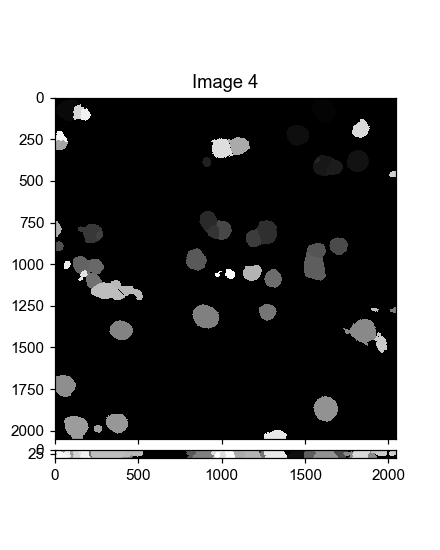

In [12]:
visual_tools.imshow_mark_3d_v2([_ref_cls.im_405, polyt_im, corr_labels3d, new_labels])

# check merlin outputs

In [14]:
import h5py

In [66]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG_test\CellPoseSegment\features\feature_data_0.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


<IPython.core.display.Javascript object>


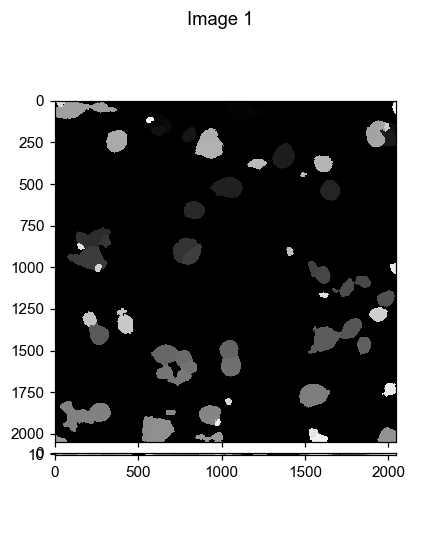

In [67]:
visual_tools.imshow_mark_3d_v2([watershed_labels])

In [8]:
merlin_feature_file = r'\\mendel\Mendel_SSD3\MERFISH_Analysis\20220525-hSTG\CellPoseSegment\features\feature_data_80.hdf5'
with h5py.File(merlin_feature_file, 'r') as _f:
    print(_f['labeldata'].keys())
    new_watershed_labels = _f['labeldata']['label3D'][:]

<KeysViewHDF5 ['label3D']>


In [46]:
from skimage import segmentation

new_labels = segmentation.watershed(
                waterIm, old_label3d, mask=waterMask,
                connectivity=np.ones((3, 3, 3)), watershed_line=True)

<IPython.core.display.Javascript object>


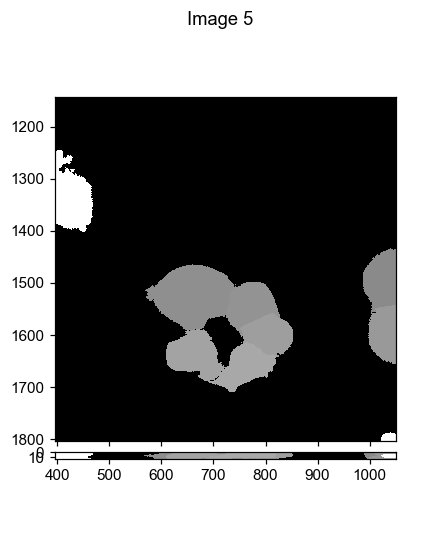

In [47]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask, old_label3d, new_labels])

In [71]:
relabel_info = pickle.load(open(r'E:\Processed_Data_Backup\202003_IMR90_chr2_repeat_relabelling\picked_relabeled_spot_pairs_2-71.pkl','rb'))

In [ ]:
visual_tools

In [85]:
relabe_zxys

array([[[2.44868031e+03, 4.69997054e+03, 7.23436359e+03, 7.48437071e+00],
        [3.73104439e+03, 4.62864729e+03, 7.40921924e+03, 2.39197063e+00],
        [2.24792957e+03, 4.69036958e+03, 7.14845435e+03, 1.58881152e+00],
        ...,
        [2.64051418e+03, 3.11798666e+03, 6.11022821e+03, 9.19883347e+00],
        [2.63617077e+03, 3.07044704e+03, 6.22241441e+03, 7.41383934e+00],
        [2.26103153e+03, 3.21625182e+03, 6.25290601e+03, 3.86180091e+00]],

       [[2.16445065e+03, 3.13107282e+03, 1.01894727e+04, 8.00683212e+00],
        [3.10189037e+03, 4.85165479e+03, 1.02543698e+04, 5.19267321e+00],
        [2.81243649e+03, 4.97361086e+03, 1.03899894e+04, 2.71444392e+00],
        ...,
        [2.79996834e+03, 3.67189906e+03, 1.06949391e+04, 2.33186173e+00],
        [2.76656399e+03, 3.55870226e+03, 1.10467400e+04, 4.68488646e+00],
        [2.73376083e+03, 3.81614900e+03, 1.05940896e+04, 1.11110854e+00]],

       [[2.97902107e+03, 1.35271961e+04, 9.24907709e+03, 2.12193418e+00],
        

In [83]:
relabe_zxys = np.load(r'\\10.245.74.158\Chromatin_NAS_4\2020_cell_materials\Chromatin_Share\Repicked_chromosome_data\before_20200512\zxyhs_final_EM_chr21_relabel.npy')

In [82]:
relabel_info['old'][1][0]

array([[ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.88830070e+01,  2.29775448e+01,  1.74338776e+02, ...,
        -6.78960886e-03, -6.34057760e-01,  5.79653076e+02],
       ...,
       [ 2.60387554e+01,  2.41951199e+01,  1.68056412e+02, ...,
         1.13709886e-02,  8.33605453e-02,  6.47226807e+02],
       [ 4.13785648e+00,  2.30000000e+01,  1.66000000e+02, ...,
         2.44903816e-07,  4.09684958e-07,  4.69725189e+02],
       [ 1.32260017e+01,  2.31380005e+01,  1.71030380e+02, ...,
         4.81985718e-01, -4.74240720e-01,  3.35760864e+02]])

In [79]:
len(relabel_info['old'][1][0])

357

In [78]:
len(relabel_info['new'][0][0])

357

In [46]:
!dir ..\..\S

 Volume in drive E is Data_01
 Volume Serial Number is B8F1-585C

 Directory of E:\Users\puzheng\Documents

05/28/2022  01:00 AM    <DIR>          .
05/28/2022  01:00 AM    <DIR>          ..
10/20/2020  12:30 AM    <DIR>          Chromatin_Analysis_2020_cell
05/26/2022  04:03 PM    <DIR>          Chromatin_Analysis_Scripts
10/20/2020  12:23 AM    <DIR>          Codes
05/26/2022  04:55 PM    <DIR>          ConvNeXt
10/20/2020  12:23 AM    <DIR>          Custom Office Templates
12/18/2020  10:12 PM             1,276 debug.log
10/20/2020  12:23 AM    <DIR>          dna-analysis
10/20/2020  12:23 AM    <DIR>          Hi-C
05/26/2022  03:09 PM    <DIR>          ImageAnalysis3
05/28/2022  01:00 AM    <DIR>          Insight3
05/27/2022  12:55 PM    <DIR>          Merfish_Analysis_Scripts
05/27/2022  12:55 PM    <DIR>          MERlin
05/26/2022  03:40 PM    <DIR>          OneNote Notebooks
05/26/2022  02:37 PM    <DIR>          Python Scripts
10/20/2020  12:23 AM    <DIR>          rdpwrap
09/3